## Reacciones y condensación

Este código calcula la evolución del nro de partículas de cada especie en función del tiempo dentro de la burbuja considerando distintos fenómenos:
* Reacciones
* Condensación

### Importo dependencias

In [1]:
#Importo dependencias
import scipy
import pandas as pd
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
#Código necesario para importar funciones de otros notebooks .ipynb

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

#Ejemplo
# from derivada_reacciones import *

In [3]:
#Importo notebooks

from parametros import *
from reacciones_qcas import *
from funciones_math import fact, erf, Vol
from condensacion_y_evaporacion import *
from funciones_qcas import *

importing Jupyter notebook from parametros.ipynb
1.673557692882144e-27
importing Jupyter notebook from reacciones_qcas.ipynb
importing Jupyter notebook from funciones_math.ipynb
importing Jupyter notebook from condensacion_y_evaporacion.ipynb
importing Jupyter notebook from conductividad_termica.ipynb
importing Jupyter notebook from funciones_qcas.ipynb


### Parámetros de la evolucicón

#### Condiciones iniciales

In [4]:
from parametros import Tinf

In [5]:
#Condiciones iniciales
#Orden:
#n[n_species] = {n[0],     n[1],   n[2],   n[3],   n[4],   n[5],   n[6],   n[7]}
#n[n_species] =      {H2,       H,      O,      O2,     OH,     H2O,    H2O2,   HO2}
#n0[n_species] = {0.0,   0.0,   0.5e8,    0.5e8,  0.0}
#n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0])
n0 = np.array([0,   0.0,    0.0,    0,  0.0,  100*1.0e8,    0.0,    0.0])


#Condiciones iniciales
R0 = 0.010263277913696248  #en [cm] (CGS). En este caso corresponde al R_cl_ini el radio del núcleo inicial luego de haberse formado a partir de los n_bubston bubstons del cluster
R0 = R0*(1/100) #en [m] (SI). Conversión (cm)*(1m/100cm)
v_R0 = 28368.86256179598# en [cm/s] (CGS). En este caso corresponde a la velocidad inicial del núcleo luego de haberse formado a partir de los n_bubston bubstons.
v_R0 = v_R0*(1/100) #en [m/s] (SI). Conversión (cm/s)*(1m/100cm)
T_bc0 = 5000# en [K] (SI). Lo extraje del Bunkin. Debería corroborar este valor
T_bi0 = T_bc0
T_li0 = Tinf
pB0 = 0


#Parámetros de la evolución química del sistema
tmax = 200e-6 #100e-6 #1.833973816e-010 // 1e5 //100e-6
# R0 = 1e-6
# Rmax = 1000e-6
T0 = Tinf
Tmax = T_bc0
sigmaT = 1e-6

def T(t):
    return (Tmax-T0)*np.exp(-0.5*pow(t/sigmaT,2)) + T0

def dTdt(t):
    return -(Tmax-T0)*np.exp(-0.5*pow(t/sigmaT,2))/sigmaT**2 * t





In [6]:
#Funciones químicas




#Función de control durante la evolución

def imprimir_nro_particulas(n_species,n,t, m0):
    #Imprime el tiempo, el nro de partículas de cada especie y la masa normalizada a la masa inicial.
    print(t, "\t", n[0], "\t", n[1], "\t", n[2], "\t", n[3], "\t", n[4], "\t", n[5], "\t", n[6], "\t", n[7], "\t", masa(n)/m0)


In [7]:
#Calculo la masa inicial
m0 = masa(n0)

In [8]:
#Importo funciones
from parametros import rapidez, var_termo
from reacciones_qcas import derivada_reacc_qcas
from condensacion_y_evaporacion import derivada_condensacion
from evolucion_radio import derivada_radio
from funciones_qcas import masa
#Importo constantes
from parametros import n_species, n_var_termo
from conductividad_termica import calculamp


importing Jupyter notebook from evolucion_radio.ipynb


In [9]:

def derivada(t, z):
    #z es el vector de variables del sistema. Está formado por 2 vectores: y de tamaño n_var_termo y n de tamaño n_species
    #y contiene las variables termodinámicas
    #n contiene el nro de partículas de cada especie

    #Separo los vectores
    y = z[0:n_var_termo]
    n = z[n_var_termo:]

    #Creo los vectores derivada
    dydt = np.zeros(n_var_termo)
    dndt = np.zeros(n_species)

    #Calculo la derivada dydt
    # nAr = 0 #Consideramos que no hay Argón
    nh2o0 = n0[5]
    dydt[var_termo["m"]], T_bi = calculamp(y, n, rapidez, nh2o0)

    #Actualizo los valores de mp y T_bi. Los necesito luego en varios módulos
    y[var_termo["mp"]] = dydt[var_termo["m"]]
    y[var_termo["T_bi"]] = T_bi

    dydt[var_termo["T_bc"]] = dTdt(t)
    dydt[var_termo["pB"]] = 0

    #Calculo la derivada dndt
    dndt = np.zeros(n_species)


    derivada_reacc_qcas(y,n,dndt)
    derivada_condensacion(y,n,dndt)
    derivada_radio(y,n,dydt)

    #Junto ambos arrays
    dzdt = np.concatenate((dydt, dndt))

    #Imprimo el nro de partículas 
    imprimir_nro_particulas(n_species,n,t, m0)
    
    return dzdt

In [10]:
from parametros import Tinf

In [11]:
#Condición inicial para z

#Inicializo el tiempo
t0 = 0.0

#Creo el vector de variables termodinámicas y lo inicializo
y0 = np.zeros(n_var_termo)
y0[var_termo["R"]] = R0
y0[var_termo["v_R"]] = v_R0
y0[var_termo["T_bc"]] = T_bc0
y0[var_termo["T_bi"]] = T_bi0
y0[var_termo["T_li"]] = T_li0
y0[var_termo["pB"]] = pB0
y0[var_termo["m"]] = masa(n0)

# nAr = 0 #Consideramos que no hay Argón
nh2o0 = n0[5]
# y0[var_termo["mp"]] = calculamp(t0 , y0, n0, rapidez, nh2o0, nAr)
#Es importante que mp se calcule último porque usa el valor de R y T

#El vector del nro de partículas inicial ya está creado

#Junto ambos arrays
z = np.concatenate((y0,n0))
z0 = z

#Creo el vector dzdt y lo inicializo
dzdt = np.zeros(n_var_termo+n_species)
dzdt = derivada(t0,z)

0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0


In [12]:
#Determina que cerca del cumplimiento del evento se tomarán más puntos
def evento_maximo(t,z):
    #Separo los vectores
    y = z[0:n_var_termo]
    n = z[n_var_termo:]
    
    return y[var_termo["v_R"]] - 0 #Que pare cuando la velocidad se hace cero (máxima expansión)


In [13]:
#Resuelvo el problema

    # //Creo el file en el que voy a ir guardando todo
    # ofstream file(archivo);
    # file << encabezado << endl;

# imprimir_nro_particulas(n_species, n, t0, m0) #imprimo la cantidad inicial de partículas de cada especie
#step es el htry, es decir, el salto que (intenta hacer?) el rkqc.

#-------------------------------------------------------------------------------------------------------------------------
#SOLUCIÓN NUMÉRICA EMPLEANDO EL MÉTODO Radau
rtol = 1e-8 #tolerancia relativa para el método numérico
soln = solve_ivp(derivada, [t0, tmax], z0, method='Radau', rtol = rtol, atol = rtol, events=evento_maximo)
#Considerando condensación, no terminó de ejecutarse al cabo de 20' con tmax = 100e-6


0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
4.8100936873604085e-15 	 0.0 	 0.015972952752590773 	 0.0 	 0.0 	 0.015972952752590773 	 10000010568.307339 	 0.0 	 0.0 	 1.0000010568323312
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 1.4901161193847657e-16 	 0.0 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 1.4901161193847657e-16 	 0.0 	 0.0 	 0.0 	 10000000000.0 	 0.0 	 0.0 	 1.0
0.0 	 0.0 	 0.0 	 1.4901161193847657e-16 	 0.0 	 0.0 	 10000000000.0 	 0.

In [14]:
print(soln) #para obtener info. sobre cómo fue la integración numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 6754
     njev: 6
      nlu: 322
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 4.81009369e-13, 3.28689080e-12, 3.13457051e-11,
       9.76818170e-11, 1.64017929e-10, 2.30354041e-10, 2.96690153e-10,
       3.63026265e-10, 4.29362377e-10, 4.95698489e-10, 5.62034601e-10,
       6.28370712e-10, 6.94706824e-10, 7.61042936e-10, 8.27379048e-10,
       8.93715160e-10, 9.60051272e-10, 1.02638738e-09, 1.09272350e-09,
       1.15905961e-09, 1.22539572e-09, 1.29173183e-09, 1.35806794e-09,
       1.42440406e-09, 1.49074017e-09, 1.55707628e-09, 1.62341239e-09,
       1.68974850e-09, 1.75608462e-09, 1.82242073e-09, 1.88875684e-09,
       1.96846771e-09, 2.04817858e-09, 2.12788946e-09, 2.20760033e-09,
       2.28731120e-09, 2.36702207e-09, 2.44673294e-09, 2.52644382e-09,
       2.60615469e-09, 2.68586556e-09, 2.76557643e-09, 2.84528730e-09,
       2.92499818e-09, 3.00470905e-09

In [15]:
#plt.figure(dpi=1200) #Para mayor resolución
# plt.loglog(soln.t, soln.y[n_var_termo + 0], label='[H2]')
# plt.loglog(soln.t, soln.y[n_var_termo + 1], label='[H]')
# plt.loglog(soln.t, soln.y[n_var_termo + 2], label='[O]')
# plt.loglog(soln.t, soln.y[n_var_termo + 3], label='[O2]')
# plt.loglog(soln.t, soln.y[n_var_termo + 4], label='[OH]')
# plt.loglog(soln.t, soln.y[n_var_termo + 5], label='[H2O]')
# plt.loglog(soln.t, soln.y[n_var_termo + 6], label='[H2O2]')
# plt.loglog(soln.t, soln.y[n_var_termo + 7], label='[HO2]')
# plt.xlabel('time [s]')
# plt.ylim([1,1e12])
# plt.ylabel('nro de particulas')
# plt.legend()
# plt.show()

# print(soln.y[n_var_termo + 0,-1])
#243953033.74080586
#243953033.74080586
#243953033.74080586

#Cambié algunos parámetros de H a Deuterio
#243921159.20272547
#243921159.20272547
#No sé qué cambió acá. Estaba trabajando sobre la funcion derivada_condensacion y derivada_calculomp_formal. Voy a asumir que el cambio se debió a cuando modifiqué H por D:
#2466608559.2100945
#2466608559.2100945
#2466608559.2100945
#2466608559.2100945
#Cambié las masas de H a las de D
# 2466593301.4378543
# 2466593301.4378543
# 2466593301.4378543
# Me fui a almorzar y al volver cambió ligeramente. No sé por qué
# 2466593303.782749
# 2466593303.782749
# 2466593303.782749
# 2466593303.782749
# Cambié el parámetro rapidez = 1 a rapidez = 0
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893
# 2485399653.851893


#2485399653.851893
#2485399653.851893
#Cambio Vol por v_R en y (es lo que debería ser)}
#2485399653.851893
#quedó el mismo valor
#2485399653.851893
#2485399653.851893
# El nro cambió porque modifiqué el cálculo de ntot en reacciones_qcas.ipynb. Lo cambié por una cuenta más rápida con numpy. Le creo a numpy
#2485398883.259361
#2485398883.259361
#2485398883.259361
#2485398883.259361
#Cambio el parámetro que mido al mismo nro con tmax = 1e-9 en lugar de tmax = 100e-6.
#99880554.93916412
#99880553.58761652 con rtol = 1e-8
#99880553.58759788 con rtol = 1e-12
#A partir de ahora trabajaré con rtol = 1e-8
#99880553.58761652
#Cambié el esquema para trabajar con la variable z
#99880553.58759782 con rtol = 1e-12

### Grafico resultados

In [16]:
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

#### R(t), v_R(t)

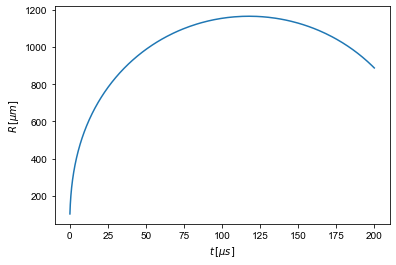

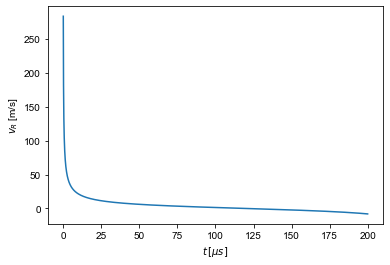

In [17]:
plt.plot(soln.t/1e-6, soln.y[var_termo["R"]]/1e-6)
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$R \, [\mu m]$')
plt.show()

plt.plot(soln.t/1e-6, soln.y[var_termo["v_R"]])
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$v_R$ [m/s]')
plt.show()

#### T_bc(t), T_bi(t), T_li(t), T_linf(T)

In [18]:
len(np.ones(2))

2

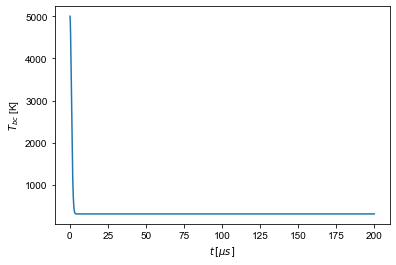

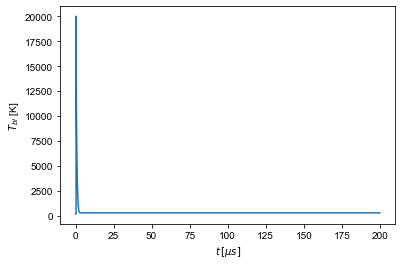

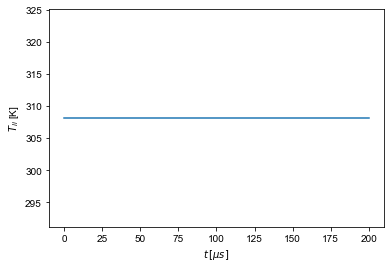

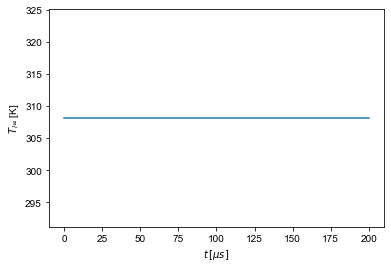

In [19]:
plt.plot(soln.t/1e-6, soln.y[var_termo["T_bc"]], label = '$T_{bc}$')
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$T_{bc}$ [K]')
plt.show()

plt.plot(soln.t/1e-6, soln.y[var_termo["T_bi"]], label = '$T_{bi}$')
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$T_{bi}$ [K]')
plt.show()

plt.plot(soln.t/1e-6, soln.y[var_termo["T_li"]], label = '$T_{li}$')
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$T_{li}$ [K]')
plt.show()

plt.plot(soln.t/1e-6, Tinf*np.ones(len(soln.t)), label = '$T_{l \infty}$')
plt.xlabel('$t \, [\mu s]$')
plt.ylabel('$T_{l \infty}$ [K]')
plt.show()

# plt.legend(fontsize = 12)



#### n_i(t)

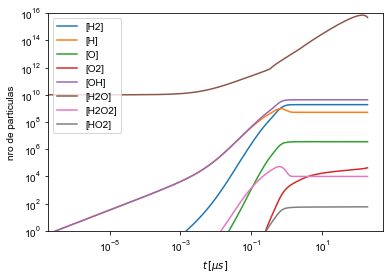

In [20]:
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 0], label='[H2]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 1], label='[H]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 2], label='[O]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 3], label='[O2]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 4], label='[OH]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 5], label='[H2O]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 6], label='[H2O2]')
plt.loglog(soln.t/1e-6, soln.y[n_var_termo + 7], label='[HO2]')
plt.xlabel('$t \, [\mu s]$')
plt.ylim([1,1e16])
plt.ylabel('nro de particulas')
plt.legend()
plt.show()


### Calculo valores de interés en R = Rmax

In [22]:
z_maximo = soln.y_events[0][0] #Vector de variables termodinamicas + nro de partículas en R = Rmax

print("El máximo ocurre a R = ", z_maximo[var_termo["R"]], ", a t = ", soln.t_events[0][0])
print("El nro de partículas de H2O es = ", z_maximo[n_var_termo + 5]/1e15, "e15")
print("El nro de partículas de H2 es = ", z_maximo[n_var_termo + 0]/1e7, "e7")
print("El nro de partículas de O2 es = ", z_maximo[n_var_termo + 3]/1e7, "e7")

El máximo ocurre a R =  0.00116491106733139 , a t =  0.00011766243871962564
El nro de partículas de H2O es =  6.955772347582061 e15
El nro de partículas de H2 es =  189.14416073726855 e7
El nro de partículas de O2 es =  0.0034126661406973587 e7


* Con sigmaT = 100e-6:  
El máximo ocurre a R =  0.0012446546233075943 , a t =  0.0001362228546843451  
El nro de partículas de H2O es =  1.6536446778862335 e15  
El nro de partículas de H2 es =  0.4891533504045494 e15  
El nro de partículas de O2 es =  0.23661765728161865 e15  
* Con sigmaT = 10e-6:  
El máximo ocurre a R =  0.0011706302878473395 , a t =  0.00011827858538759363  
El nro de partículas de H2O es =  7.048078343313752 e15  
El nro de partículas de H2 es =  0.0021010484534605676 e15  
El nro de partículas de O2 es =  0.0002778382870657421 e15  

* Con sigmaT = 1e-6:
El máximo ocurre a R =  0.00116491106733139 , a t =  0.00011766243871962564  
El nro de partículas de H2O es =  6.955772347582061 e15  
El nro de partículas de H2 es =  189.14416073726855 e7  
El nro de partículas de O2 es =  0.0034126661406973587 e7  


